# Testing Code


Before submiting the final answers, this jupyter notebook could be used to experiment and verify if the code is working!


Here we are taking inspiration from two of the top projects:
 * https://huggingface.co/spaces/baixianger/RobotPai
 * https://huggingface.co/spaces/fisherman611/gaia-agent/

In [ ]:
%load_ext autoreload
%autoreload 2

## Imports

In [5]:
import json

## Load Data

In [6]:
# Load the metadata.jsonl file
with open('data/metadata.jsonl', 'r') as jsonl_file:
    json_list = list(jsonl_file)

json_QA = []
for json_str in json_list:
    json_data = json.loads(json_str)
    json_QA.append(json_data)

### Data Analyses

Here we analyze the data in order to find what tools we need to build a robust agent

In [7]:
import random

random_samples = random.sample(json_QA, 3)
for sample in random_samples:
    print("=" * 50)
    print(f"Task ID: {sample['task_id']}")
    print(f"Question: {sample['Question']}")
    print(f"Level: {sample['Level']}")
    print(f"Final Answer: {sample['Final answer']}")
    print(f"Annotator Metadata: ")
    print(f"  ├── Steps: ")
    for step in sample['Annotator Metadata']['Steps'].split('\n'):
        print(f"  │      ├── {step}")
    print(f"  ├── Number of steps: {sample['Annotator Metadata']['Number of steps']}")
    print(f"  ├── How long did this take?: {sample['Annotator Metadata']['How long did this take?']}")
    print(f"  ├── Tools:")
    for tool in sample['Annotator Metadata']['Tools'].split('\n'):
        print(f"  │      ├── {tool}")
    print(f"  └── Number of tools: {sample['Annotator Metadata']['Number of tools']}")
print("=" * 50)

Task ID: 8b3379c0-0981-4f5b-8407-6444610cb212
Question: What is the maximum length in meters of #9 in the first National Geographic short on YouTube that was ever released according to the Monterey Bay Aquarium website? Just give the number.
Level: 2
Final Answer: 1.8
Annotator Metadata: 
  ├── Steps: 
  │      ├── 1. Searched "National Geographic YouTube" on Google search.
  │      ├── 2. Opened the National Geographic YouTube channel.
  │      ├── 3. Clicked "Shorts".
  │      ├── 4. Watched the oldest short ("Which shark species is the most massive? #SharkFest #Shorts") and noted #9 (Blacktip Reef).
  │      ├── 5. Searched "blacktip reef monterey bay aquarium" on Google search.
  │      ├── 6. Opened "Blacktip reef shark" on the Monterey Bay Aquarium website and noted the maximum length.
  ├── Number of steps: 6
  ├── How long did this take?: 10 minutes
  ├── Tools:
  │      ├── 1. Web browser
  │      ├── 2. Search engine
  │      ├── 3. Video recognition tools
  └── Number of too

In [8]:
### Linking to supabase server
import os
from dotenv import load_dotenv
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_community.vectorstores import SupabaseVectorStore
from supabase.client import Client, create_client


load_dotenv()
embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-mpnet-base-v2") #  dim=768

supabase_url = os.environ.get("SUPABASE_URL")
supabase_key = os.environ.get("SUPABASE_SERVICE_KEY")
supabase: Client = create_client(supabase_url, supabase_key)

In [ ]:
json_QA

In [ ]:
# Questions to list of documents
from langchain.schema import Document
import uuid

docs = []
for sample in json_QA:
    content = f"Question : {sample['Question']}\n\nFinal answer : {sample['Final answer']}"
    doc = {
        "id": str(uuid.uuid4()),  # 手动生成 UUID
        "content" : content,
        "metadata" : { 
            "source" : sample['task_id']
        },
        "embedding" : embeddings.embed_query(content),
    }
    docs.append(doc)

print('docs')
print(docs[0])
# upload the documents to the vector database
try:
    response = supabase.table("documents").insert(docs).execute()
    print("Data inserted successfully:", response)
except Exception as e:
    print("Error inserting data into Supabase:", e)

In [9]:
# add items to vector database
vector_store = SupabaseVectorStore(
    client=supabase,
    embedding= embeddings,
    table_name="documents",
    query_name="match_documents",
)
retriever = vector_store.as_retriever()

In [10]:
query = "On June 6, 2023, an article by Carolyn Collins Petersen was published in Universe Today. This article mentions a team that produced a paper about their observations, linked at the bottom of the article. Find this paper. Under what NASA award number was the work performed by R. G. Arendt supported by?"
# matched_docs = vector_store.similarity_search(query, 2)
docs = retriever.invoke(query)
docs[0]

Document(metadata={'source': '840bfca7-4f7b-481a-8794-c560c340185d'}, page_content='Question : On June 6, 2023, an article by Carolyn Collins Petersen was published in Universe Today. This article mentions a team that produced a paper about their observations, linked at the bottom of the article. Find this paper. Under what NASA award number was the work performed by R. G. Arendt supported by?\n\nFinal answer : 80GSFC21M0002')

In [11]:
from collections import Counter, OrderedDict

tools = []
for sample in json_QA:
    for tool in sample['Annotator Metadata']['Tools'].split('\n'):
        tool = tool[2:].strip().lower()
        if tool.startswith("("):
            tool = tool[11:].strip()
        tools.append(tool)
tools_counter = OrderedDict(Counter(tools))
print("List of tools used in all samples:")
print("Total number of tools used:", len(tools_counter))
for tool, count in tools_counter.items():
    print(f"  ├── {tool}: {count}")

List of tools used in all samples:
Total number of tools used: 83
  ├── web browser: 107
  ├── image recognition tools (to identify and parse a figure with three axes): 1
  ├── search engine: 101
  ├── calculator: 34
  ├── unlambda compiler (optional): 1
  ├── a web browser.: 2
  ├── a search engine.: 2
  ├── a calculator.: 1
  ├── microsoft excel: 5
  ├── google search: 1
  ├── ne: 9
  ├── pdf access: 7
  ├── file handling: 2
  ├── python: 3
  ├── image recognition tools: 12
  ├── jsonld file access: 1
  ├── video parsing: 1
  ├── python compiler: 1
  ├── video recognition tools: 3
  ├── pdf viewer: 7
  ├── microsoft excel / google sheets: 3
  ├── word document access: 1
  ├── tool to extract text from images: 1
  ├── a word reversal tool / script: 1
  ├── counter: 1
  ├── excel: 3
  ├── image recognition: 5
  ├── color recognition: 3
  ├── excel file access: 3
  ├── xml file access: 1
  ├── access to the internet archive, web.archive.org: 1
  ├── text processing/diff tool: 1
  ├── gi

## Graph Implementation

Here we build the agent graph with LangGraph to solve those tasks!

In [12]:
system_prompt = """
You are a helpful assistant tasked with answering questions using a set of tools.
If the tool is not available, you can try to find the information online. You can also use your own knowledge to answer the question. 
You need to provide a step-by-step explanation of how you arrived at the answer.
==========================
Here is a few examples showing you how to answer the question step by step.
"""
for i, samples in enumerate(random_samples):
    system_prompt += f"\nQuestion {i+1}: {samples['Question']}\nSteps:\n{samples['Annotator Metadata']['Steps']}\nTools:\n{samples['Annotator Metadata']['Tools']}\nFinal Answer: {samples['Final answer']}\n"
system_prompt += "\n==========================\n"
system_prompt += "Now, I will ask you a question. Please answer the question step by step. Report your thoughts, and finish your answer with the following template: \n"
system_prompt += "FINAL ANSWER: [YOUR FINAL ANSWER]. \n"
system_prompt += "YOUR FINAL ANSWER should be a number OR as few words as possible OR a comma separated list of numbers and/or strings. If you are asked for a number, don't use comma to write your number neither use units such as $ or percent sign unless specified otherwise. If you are asked for a string, don't use articles, neither abbreviations (e.g. for cities), and write the digits in plain text unless specified otherwise. If you are asked for a comma separated list, Apply the rules above for each element (number or string), ensure there is exactly one space after each comma.\n"
system_prompt += "Your answer should only start with 'FINAL ANSWER: ', then follows with the answer.\n"

# save the system_prompt to a file
with open('system_prompt.txt', 'w') as f:
    f.write(system_prompt)

In [13]:
# load the system prompt from the file
with open('system_prompt.txt', 'r') as f:
    system_prompt = f.read()
print(system_prompt)


You are a helpful assistant tasked with answering questions using a set of tools.
If the tool is not available, you can try to find the information online. You can also use your own knowledge to answer the question. 
You need to provide a step-by-step explanation of how you arrived at the answer.
Here is a few examples showing you how to answer the question step by step.

Question 1: What is the maximum length in meters of #9 in the first National Geographic short on YouTube that was ever released according to the Monterey Bay Aquarium website? Just give the number.
Steps:
1. Searched "National Geographic YouTube" on Google search.
2. Opened the National Geographic YouTube channel.
3. Clicked "Shorts".
4. Watched the oldest short ("Which shark species is the most massive? #SharkFest #Shorts") and noted #9 (Blacktip Reef).
5. Searched "blacktip reef monterey bay aquarium" on Google search.
6. Opened "Blacktip reef shark" on the Monterey Bay Aquarium website and noted the maximum length

In [24]:
import dotenv
from langgraph.graph import MessagesState, START, StateGraph
from langgraph.prebuilt import tools_condition
from langgraph.prebuilt import ToolNode
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, SystemMessage
from tools.searchtools import question_retrieve_tool, wiki_search, web_search, arxiv_search
from tools.mathtools import multiply, add, subtract, divide, modulus
from tools.documenttools import download_file_from_url, save_and_read_file, extract_text_from_image, analyze_csv_file, analyze_excel_file
from tools.audiotools import transcribe_audio
from tools.codetools import execute_code_multilang

# Define the retriever from supabase
load_dotenv()

tools = [
    multiply,
    add,
    subtract,
    divide,
    modulus,
    wiki_search,
    web_search,
    arxiv_search,
    question_retrieve_tool,
    download_file_from_url,
    save_and_read_file,
    extract_text_from_image,
    analyze_csv_file,
    analyze_excel_file,
    execute_code_multilang,
    transcribe_audio
]

llm = ChatOpenAI(
    model="gpt-4o",
    temperature=0,
    api_key=os.environ.get("OPENAI_API_KEY")
)
llm_with_tools = llm.bind_tools(tools)

In [26]:
# load the system prompt from the file
with open('system_prompt.txt', 'r') as f:
    system_prompt = f.read()


# System message
sys_msg = SystemMessage(content=system_prompt)

# Node
def assistant(state: MessagesState):
    """Assistant node"""
    return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")

# Compile graph
graph = builder.compile()

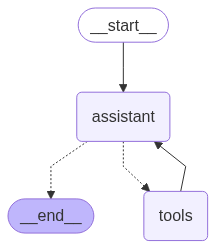

In [36]:
from IPython.display import Image, display

display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [27]:
question = "Hi, I'm making a pie but I could use some help with my shopping list. I have everything I need for the crust, but I'm not sure about the filling. I got the recipe from my friend Aditi, but she left it as a voice memo and the speaker on my phone is buzzing so I can't quite make out what she's saying. Could you please listen to the recipe and list all of the ingredients that my friend described? I only want the ingredients for the filling, as I have everything I need to make my favorite pie crust. I've attached the recipe as Strawberry pie.mp3.\n\nIn your response, please only list the ingredients, not any measurements. So if the recipe calls for \"a pinch of salt\" or \"two cups of ripe strawberries\" the ingredients on the list would be \"salt\" and \"ripe strawberries\".\n\nPlease format your response as a comma separated list of ingredients. Also, please alphabetize the ingredients."
messages = [HumanMessage(content=question)]
messages = graph.invoke({"messages": messages})

In [28]:
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Hi, I'm making a pie but I could use some help with my shopping list. I have everything I need for the crust, but I'm not sure about the filling. I got the recipe from my friend Aditi, but she left it as a voice memo and the speaker on my phone is buzzing so I can't quite make out what she's saying. Could you please listen to the recipe and list all of the ingredients that my friend described? I only want the ingredients for the filling, as I have everything I need to make my favorite pie crust. I've attached the recipe as Strawberry pie.mp3.

In your response, please only list the ingredients, not any measurements. So if the recipe calls for "a pinch of salt" or "two cups of ripe strawberries" the ingredients on the list would be "salt" and "ripe strawberries".

Please format your response as a comma separated list of ingredients. Also, please alphabetize the ingredients.
================================